In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import mean_squared_error, r2_score
import os.path
from preprocessing import *
from skorch import NeuralNetRegressor
from torch import nn, optim
from skorch.callbacks import EarlyStopping
from skorch.callbacks import EpochScoring
import matplotlib.pyplot as plt

c:\Users\paola\anaconda3\envs\MLCourse\lib\site-packages\dask\dataframe\__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
'''
np.random.seed(10)

X_file = "data/X_matrix.csv"
Y_file = "data/Y_matrix.csv"

print("Loading the data...")
x_df = pd.read_csv(X_file)
y_df = pd.read_csv(Y_file)
x_data_f, y_data_f = preprocessed_data(x_df, y_df)

#x, y, x_test_try = preprocessed_data(path_train, path_cddd, path_test)
'''

Loading the data...


In [2]:
X_file = "data/X_matrix.csv"
Y_file = "data/Y_matrix.csv"

print("Loading and preprocessing the data...")

# Load the column names (header)
column_names = np.genfromtxt(X_file, delimiter=',', max_rows=1, dtype=str)[1:]  # Skip the first column if it's row names

# Load the row names (index) from the first column and the data (excluding first column)
data = np.loadtxt(X_file, delimiter=',', skiprows=1, usecols=range(1, 348523))
row_names = np.loadtxt(X_file, delimiter=',', skiprows=1, usecols=0, dtype=str)

# Create the DataFrame
x2_df = pd.DataFrame(data, index=row_names, columns=column_names)
x2_df = pd.DataFrame(data, columns=column_names)

print("moving to y")
y2_df = pd.read_csv(Y_file)
print("three")

x_data_f = x2_df.drop(x2_df.columns[0], axis=1)
y_data_f = y2_df.drop(y2_df.columns[0], axis=1)

x_data_f, y_data_f = preprocessed_data(x_data_f, y_data_f, y=True)




Loading and preprocessing the data...
moving to y
three
The DataFrame does not contain any NaN values.
1
The DataFrame does not contain any NaN values.
2
The DataFrame does not contain any NaN values.
3


In [23]:
print(y_data_f.shape)

(792, 1)


In [10]:
print(y_data_f.shape)
y_data_f.head
print(Y_pred.shape)

(792, 1)
(792,)


Préparation des données...
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.0878        0.0278  5.5378
      2        0.0261        0.0190  5.7531
      3        0.0153        0.0137  5.5954
      4        0.0144        0.0144  5.3699
      5        0.0099        0.0087  5.3699
      6        0.0095        0.0104  5.3639
      7        0.0088        0.0100  5.3948
      8        0.0091        0.0104  5.4496
      9        0.0068        0.0097  5.4882
Stopping since valid_loss has not improved in the last 5 epochs.
Best Parameters: {'lr': 0.00015, 'max_epochs': 20, 'module__dropout_rate': 0.012, 'optimizer': <class 'torch.optim.adam.Adam'>}
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1       -0.1763       -0.0293  2.1962
      2       -0.0436       -0.0332  2.1549
      3       -0.0335       -0.0194  2.3947
      4       -0.0266       -0.0227  2.3262
      5       -0.0209       -0.0

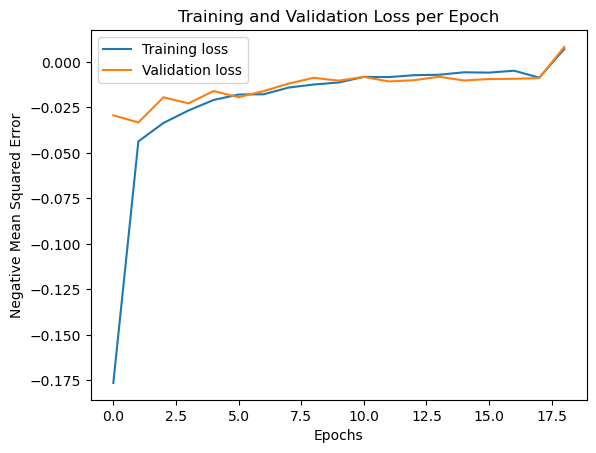

In [9]:
#V3

# Préparation des données
print("Préparation des données...")

# Number of input features
n_input_features = x_data_f.shape[1]

# Define an enhanced neural network
class EnhancedRegressionNet(nn.Module):
    def __init__(self, n_input_features, dropout_rate, n_neurons=128):
        super(EnhancedRegressionNet, self).__init__()
        self.fc1 = nn.Linear(n_input_features, n_neurons)  # n_input_features
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(n_neurons, n_neurons)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout_rate)
        self.fc3 = nn.Linear(n_neurons, 1)  # Output layer remains 2D

    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.dropout1(x)
        x = self.relu2(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x  # Do not squeeze the output; output remains shape [batch_size, 1]

# Ensure both x_data_f and y_data_f are converted to float32
x_data_f = x_data_f.astype(np.float32)  # Cast features to float32
y_data_f = y_data_f.astype(np.float32)  # Cast target to float32

# Define scoring callbacks for training and validation loss
train_loss = EpochScoring(scoring='neg_mean_squared_error', on_train=True, name='train_loss', lower_is_better=False)
valid_loss = EpochScoring(scoring='neg_mean_squared_error', name='valid_loss', lower_is_better=False)

# Neural Network Regressor
net = NeuralNetRegressor(
    module=EnhancedRegressionNet,
    module__n_input_features=n_input_features,  # n_input_features
    criterion=nn.MSELoss,
    optimizer=optim.Adam,
    iterator_train__shuffle=True,
    iterator_train__batch_size=32,
    callbacks=[EarlyStopping(patience=5)],
    verbose=1
)

# Parameter grid
param_grid = {
    'module__dropout_rate': [0.011, 0.012],
    'lr': [0.00015, 0.00017],
    'max_epochs': [20],
    'optimizer': [optim.Adam],
}

# GridSearchCV
grid_search = GridSearchCV(net, param_grid=param_grid, cv=KFold(n_splits=6), scoring='neg_mean_squared_error', n_jobs=2)

# Ensure y_data_f has the correct shape (2D) for PyTorch
y_data_f_reshaped = y_data_f.reshape(-1, 1)

# Fit the grid search
grid_search.fit(x_data_f.values, y_data_f_reshaped)

# Get the best parameters from the grid search
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Training of the model
best_net = NeuralNetRegressor(
    module=EnhancedRegressionNet,
    module__n_input_features=n_input_features,
    module__n_neurons=128,
    module__dropout_rate=best_params['module__dropout_rate'],
    criterion=nn.MSELoss,
    max_epochs=best_params['max_epochs'],
    optimizer=best_params['optimizer'],
    lr=best_params['lr'],
    iterator_train__shuffle=True,
    callbacks=[EarlyStopping(patience=5), train_loss, valid_loss],
    verbose=1
)

# Train the final model
best_net.fit(x_data_f.values, y_data_f_reshaped)

# Predictions
Y_pred = best_net.predict(x_data_f.values)

# Reshape predictions for consistency (if needed)
Y_pred = Y_pred.reshape(-1, 1)

# Rescale predictions if necessary (using y_reverse, if required)
Y_pred_rev = y_reverse(Y_pred)  # Uncomment if using y_reverse function

# Create a DataFrame with predictions
id_array = np.arange(1, len(Y_pred) + 1)
final_df = pd.DataFrame({
    'ID': id_array,
    'division_rate': Y_pred_rev.flatten()
})

# Save the new DataFrame to a CSV file
final_csv = final_df.to_csv("Data\\results_nn3.csv", index=False)

# Evaluate the model
mse = mean_squared_error(y_data_f_reshaped, Y_pred)
print(f'Mean Squared Error: {mse}')
r2 = r2_score(y_data_f_reshaped, Y_pred)
print(f'R2 score: {r2}')

# Extract training and validation loss for a plot
train_losses = best_net.history[:, 'train_loss']
valid_losses = best_net.history[:, 'valid_loss']

# Plot training and validation loss
plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Negative Mean Squared Error')
plt.title('Training and Validation Loss per Epoch')
plt.legend()
plt.savefig("Data\\NNplot_nn3.png")
plt.show()


In [4]:
#V2

# Préparation des données
print("Préparation des données...")

# Number of input features
n_input_features = x_data_f.shape[1]

# Define an enhanced neural network
class EnhancedRegressionNet(nn.Module):
    def __init__(self, n_input_features, dropout_rate, n_neurons=128):
        super(EnhancedRegressionNet, self).__init__()
        self.fc1 = nn.Linear(n_input_features, n_neurons)  # n_input_features
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(n_neurons, n_neurons)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout_rate)
        self.fc3 = nn.Linear(n_neurons, 1)  # Output layer remains 2D

    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.dropout1(x)
        x = self.relu2(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x  # Do not squeeze the output; output remains shape [batch_size, 1]

# Define scoring callbacks for training and validation loss
train_loss = EpochScoring(scoring='neg_mean_squared_error', on_train=True, name='train_loss', lower_is_better=False)
valid_loss = EpochScoring(scoring='neg_mean_squared_error', name='valid_loss', lower_is_better=False)

# Neural Network Regressor
net = NeuralNetRegressor(
    module=EnhancedRegressionNet,
    module__n_input_features=n_input_features,  # n_input_features
    criterion=nn.MSELoss,
    optimizer=optim.Adam,
    iterator_train__shuffle=True,
    iterator_train__batch_size=32,
    callbacks=[EarlyStopping(patience=5)],
    verbose=1
)

# Parameter grid
param_grid = {
    'module__dropout_rate': [0.011, 0.012],
    'lr': [0.00015, 0.00017],
    'max_epochs': [20],
    'optimizer': [optim.Adam],
}

# GridSearchCV
grid_search = GridSearchCV(net, param_grid=param_grid, cv=KFold(n_splits=6), scoring='neg_mean_squared_error', n_jobs=-1)

# **Fix: Squeeze the target values to match the model output**
#y_data_f_squeezed = y_data_f.values.astype(np.float32).squeeze()  # Remove the last dimension

# Fit the grid search
grid_search.fit(x_data_f.values.astype(np.float32), y_data_f)

# Get the best parameters from the grid search
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Training of the model
best_net = NeuralNetRegressor(
    module=EnhancedRegressionNet,
    module__n_input_features=n_input_features,
    module__n_neurons=128,
    module__dropout_rate=best_params['module__dropout_rate'],
    criterion=nn.MSELoss,
    max_epochs=best_params['max_epochs'],
    optimizer=best_params['optimizer'],
    lr=best_params['lr'],
    iterator_train__shuffle=True,
    callbacks=[EarlyStopping(patience=5), train_loss, valid_loss],
    verbose=1
)

# **Use the squeezed target values for training**
best_net.fit(x_data_f.values.astype(np.float32), y_data_f)

# Predictions
Y_pred = best_net.predict(x_data_f.values.astype(np.float32))

# Fix: Ensure predictions are reshaped for consistency if needed
Y_pred = Y_pred.reshape(-1, 1)  
Y_pred_rev = y_reverse(Y_pred)

# Create a DataFrame with predictions
id_array = np.arange(1, len(Y_pred) + 1)
final_df = pd.DataFrame({
    'ID': id_array,
    'division_rate': Y_pred.flatten()
})

# Save the new DataFrame to a CSV file
final_csv = final_df.to_csv("Data\\results_nn3.csv", index=False)

# Evaluate the model
mse = mean_squared_error(y_data_f, Y_pred)
print(f'Mean Squared Error: {mse}')
r2 = r2_score(y_data_f, Y_pred)
print(f'R2 score: {r2}')

# Extract training and validation loss for a plot
train_losses = best_net.history[:, 'train_loss']
valid_losses = best_net.history[:, 'valid_loss']

# Plot training and validation loss
plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Negative Mean Squared Error')
plt.title('Training and Validation Loss per Epoch')
plt.legend()
plt.savefig("Data\\NNplot_nn3.png")
plt.show()


Préparation des données...


ValueError: 
All the 24 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
24 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\paola\anaconda3\envs\MLCourse\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\paola\anaconda3\envs\MLCourse\lib\site-packages\skorch\regressor.py", line 82, in fit
    return super(NeuralNetRegressor, self).fit(X, y, **fit_params)
  File "c:\Users\paola\anaconda3\envs\MLCourse\lib\site-packages\skorch\net.py", line 1319, in fit
    self.partial_fit(X, y, **fit_params)
  File "c:\Users\paola\anaconda3\envs\MLCourse\lib\site-packages\skorch\net.py", line 1278, in partial_fit
    self.fit_loop(X, y, **fit_params)
  File "c:\Users\paola\anaconda3\envs\MLCourse\lib\site-packages\skorch\net.py", line 1190, in fit_loop
    self.run_single_epoch(iterator_train, training=True, prefix="train",
  File "c:\Users\paola\anaconda3\envs\MLCourse\lib\site-packages\skorch\net.py", line 1226, in run_single_epoch
    step = step_fn(batch, **fit_params)
  File "c:\Users\paola\anaconda3\envs\MLCourse\lib\site-packages\skorch\net.py", line 1105, in train_step
    self._step_optimizer(step_fn)
  File "c:\Users\paola\anaconda3\envs\MLCourse\lib\site-packages\skorch\net.py", line 1060, in _step_optimizer
    optimizer.step(step_fn)
  File "c:\Users\paola\anaconda3\envs\MLCourse\lib\site-packages\torch\optim\optimizer.py", line 373, in wrapper
    out = func(*args, **kwargs)
  File "c:\Users\paola\anaconda3\envs\MLCourse\lib\site-packages\torch\optim\optimizer.py", line 76, in _use_grad
    ret = func(self, *args, **kwargs)
  File "c:\Users\paola\anaconda3\envs\MLCourse\lib\site-packages\torch\optim\adam.py", line 143, in step
    loss = closure()
  File "c:\Users\paola\anaconda3\envs\MLCourse\lib\site-packages\skorch\net.py", line 1094, in step_fn
    step = self.train_step_single(batch, **fit_params)
  File "c:\Users\paola\anaconda3\envs\MLCourse\lib\site-packages\skorch\net.py", line 995, in train_step_single
    loss.backward()
  File "c:\Users\paola\anaconda3\envs\MLCourse\lib\site-packages\torch\_tensor.py", line 492, in backward
    torch.autograd.backward(
  File "c:\Users\paola\anaconda3\envs\MLCourse\lib\site-packages\torch\autograd\__init__.py", line 251, in backward
    Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
RuntimeError: Found dtype Double but expected Float


Préparation des données...


c:\Users\paola\anaconda3\envs\MLCourse\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\paola\anaconda3\envs\MLCourse\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([25, 1])) that is different to the input size (torch.Size([25])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.0739        0.0866  7.3849


c:\Users\paola\anaconda3\envs\MLCourse\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([128, 1])) that is different to the input size (torch.Size([128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\paola\anaconda3\envs\MLCourse\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([31, 1])) that is different to the input size (torch.Size([31])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


      2        0.0689        0.0854  6.8601
      3        0.0466        0.0844  6.7317
      4        0.0457        0.0847  7.0510
      5        0.0440        0.0852  6.6748
      6        0.0437        0.0846  6.4815
      7        0.0433        0.0842  6.3643
      8        0.0428        0.0840  6.1194
      9        0.0431        0.0844  6.5441
     10        0.0430        0.0843  6.4121
     11        0.0427        0.0841  6.1285
     12        0.0425        0.0843  5.8971
Stopping since valid_loss has not improved in the last 5 epochs.
Best Parameters: {'lr': 0.00015, 'max_epochs': 20, 'module__dropout_rate': 0.011, 'optimizer': <class 'torch.optim.adam.Adam'>}


c:\Users\paola\anaconda3\envs\MLCourse\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([121, 1])) that is different to the input size (torch.Size([121])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1       -0.2971       -0.0882  2.3836


c:\Users\paola\anaconda3\envs\MLCourse\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([128, 1])) that is different to the input size (torch.Size([128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\paola\anaconda3\envs\MLCourse\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([121, 1])) that is different to the input size (torch.Size([121])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


      2       -0.0453       -0.0857  2.2393


c:\Users\paola\anaconda3\envs\MLCourse\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([31, 1])) that is different to the input size (torch.Size([31])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\paola\anaconda3\envs\MLCourse\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([128, 1])) that is different to the input size (torch.Size([128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\paola\anaconda3\envs\MLCourse\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([121, 1])) that is different to the input size (torch.Size([121])). This will likely lead to incorrect results due to broadcasting. Please ens

      3       -0.0524       -0.0848  2.2999


c:\Users\paola\anaconda3\envs\MLCourse\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([31, 1])) that is different to the input size (torch.Size([31])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\paola\anaconda3\envs\MLCourse\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([128, 1])) that is different to the input size (torch.Size([128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\paola\anaconda3\envs\MLCourse\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([121, 1])) that is different to the input size (torch.Size([121])). This will likely lead to incorrect results due to broadcasting. Please ens

      4       -0.0489       -0.0867  2.1769


c:\Users\paola\anaconda3\envs\MLCourse\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([31, 1])) that is different to the input size (torch.Size([31])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\paola\anaconda3\envs\MLCourse\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([128, 1])) that is different to the input size (torch.Size([128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\paola\anaconda3\envs\MLCourse\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([121, 1])) that is different to the input size (torch.Size([121])). This will likely lead to incorrect results due to broadcasting. Please ens

      5       -0.0485       -0.0850  2.1170


c:\Users\paola\anaconda3\envs\MLCourse\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([31, 1])) that is different to the input size (torch.Size([31])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\paola\anaconda3\envs\MLCourse\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([128, 1])) that is different to the input size (torch.Size([128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\paola\anaconda3\envs\MLCourse\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([121, 1])) that is different to the input size (torch.Size([121])). This will likely lead to incorrect results due to broadcasting. Please ens

      6       -0.0458       -0.0851  2.1845


c:\Users\paola\anaconda3\envs\MLCourse\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([31, 1])) that is different to the input size (torch.Size([31])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\paola\anaconda3\envs\MLCourse\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([128, 1])) that is different to the input size (torch.Size([128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\paola\anaconda3\envs\MLCourse\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([121, 1])) that is different to the input size (torch.Size([121])). This will likely lead to incorrect results due to broadcasting. Please ens

      7       -0.0459       -0.0842  2.1675


c:\Users\paola\anaconda3\envs\MLCourse\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([31, 1])) that is different to the input size (torch.Size([31])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\paola\anaconda3\envs\MLCourse\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([128, 1])) that is different to the input size (torch.Size([128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\paola\anaconda3\envs\MLCourse\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([121, 1])) that is different to the input size (torch.Size([121])). This will likely lead to incorrect results due to broadcasting. Please ens

      8       -0.0448       -0.0847  2.2306


c:\Users\paola\anaconda3\envs\MLCourse\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([31, 1])) that is different to the input size (torch.Size([31])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\paola\anaconda3\envs\MLCourse\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([128, 1])) that is different to the input size (torch.Size([128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\paola\anaconda3\envs\MLCourse\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([121, 1])) that is different to the input size (torch.Size([121])). This will likely lead to incorrect results due to broadcasting. Please ens

      9       -0.0454       -0.0836  2.2131


c:\Users\paola\anaconda3\envs\MLCourse\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([31, 1])) that is different to the input size (torch.Size([31])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\paola\anaconda3\envs\MLCourse\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([128, 1])) that is different to the input size (torch.Size([128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\paola\anaconda3\envs\MLCourse\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([121, 1])) that is different to the input size (torch.Size([121])). This will likely lead to incorrect results due to broadcasting. Please ens

     10       -0.0447       -0.0834  2.1883


c:\Users\paola\anaconda3\envs\MLCourse\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([31, 1])) that is different to the input size (torch.Size([31])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\paola\anaconda3\envs\MLCourse\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([128, 1])) that is different to the input size (torch.Size([128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\paola\anaconda3\envs\MLCourse\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([121, 1])) that is different to the input size (torch.Size([121])). This will likely lead to incorrect results due to broadcasting. Please ens

     11       -0.0434       -0.0835  2.2023


c:\Users\paola\anaconda3\envs\MLCourse\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([31, 1])) that is different to the input size (torch.Size([31])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\paola\anaconda3\envs\MLCourse\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([128, 1])) that is different to the input size (torch.Size([128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\paola\anaconda3\envs\MLCourse\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([121, 1])) that is different to the input size (torch.Size([121])). This will likely lead to incorrect results due to broadcasting. Please ens

     12       -0.0441       -0.0849  2.1438


c:\Users\paola\anaconda3\envs\MLCourse\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([31, 1])) that is different to the input size (torch.Size([31])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\paola\anaconda3\envs\MLCourse\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([128, 1])) that is different to the input size (torch.Size([128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\paola\anaconda3\envs\MLCourse\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([121, 1])) that is different to the input size (torch.Size([121])). This will likely lead to incorrect results due to broadcasting. Please ens

Stopping since valid_loss has not improved in the last 5 epochs.
Mean Squared Error: 0.05053408454815331
R2 score: -0.007672996479935579


KeyboardInterrupt: 

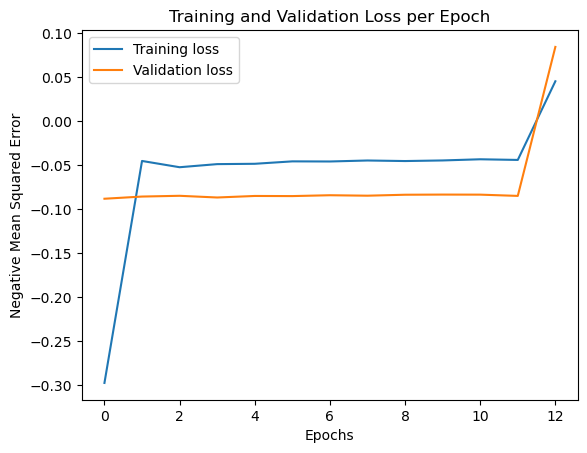

In [ ]:
#V1
# Préparation des données
print("Préparation des données...")

# Number of input features
n_input_features = x_data_f.shape[1]

# Define an enhanced neural network
class EnhancedRegressionNet(nn.Module):
    def __init__(self, n_input_features, dropout_rate, n_neurons=128):
        super(EnhancedRegressionNet, self).__init__()
        self.fc1 = nn.Linear(n_input_features, n_neurons) #n_input_features
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(n_neurons, n_neurons)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout_rate)
        self.fc3 = nn.Linear(n_neurons, 1)

    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.dropout1(x)
        x = self.relu2(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x.squeeze()


# Define scoring callbacks for training and validation loss
train_loss = EpochScoring(scoring='neg_mean_squared_error', on_train=True, name='train_loss', lower_is_better=False)
valid_loss = EpochScoring(scoring='neg_mean_squared_error', name='valid_loss', lower_is_better=False)


#Neural Network Regressor
net = NeuralNetRegressor(
    module=EnhancedRegressionNet,
    module__n_input_features=n_input_features , #n_input_features
    criterion=nn.MSELoss,
    optimizer=optim.Adam,
    iterator_train__shuffle=True,
    iterator_train__batch_size = 32,
    callbacks=[EarlyStopping(patience=5)],
    verbose=1
)

#parameter grid
param_grid = {
    'module__dropout_rate': [0.011, 0.012],
    'lr': [0.00015, 0.00017],
    'max_epochs': [20],
    'optimizer': [optim.Adam],
}


# GridSearchCV 
grid_search = GridSearchCV(net, param_grid=param_grid, cv=KFold(n_splits=6), scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(x_data_f.values.astype(np.float32), y_data_f.values.astype(np.float32))

# Get the best parameters from the grid search
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Training of the model
best_net = NeuralNetRegressor(
    module=EnhancedRegressionNet,
    module__n_input_features=n_input_features,
    module__n_neurons=128,
    module__dropout_rate=best_params['module__dropout_rate'],
    criterion=nn.MSELoss,
    max_epochs=best_params['max_epochs'],
    optimizer=best_params['optimizer'],
    lr=best_params['lr'],
    iterator_train__shuffle=True,
    callbacks=[EarlyStopping(patience=5), train_loss, valid_loss],
    verbose=1
)
best_net.fit(x_data_f.values.astype(np.float32), y_data_f.values.astype(np.float32))

Y_pred = best_net.predict(x_data_f.values.astype(np.float32))

id_array = np.arange(1, len(Y_pred)+1)
final_df = pd.DataFrame({
    'ID': id_array,
    'division_rate': Y_pred.flatten()
})

#pour que ça run tout en même temps
mse = mean_squared_error(y_data_f, Y_pred)
print(f'Mean Squared Error: {mse}')
r2 = r2_score(y_data_f, Y_pred)
print(f'R2 score: {r2}')

# Save the new DataFrame to a CSV file
final_csv = final_df.to_csv("Data\\results_nn3.csv", index=False)

# Extract training and validation loss for a plot
train_losses = best_net.history[:, 'train_loss']
valid_losses = best_net.history[:, 'valid_loss']

plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Negative Mean Squared Error')
plt.title('Training and Validation Loss per Epoch')
plt.legend()
plt.savefig("Data\\NNplot_nn3.png")

'''
In a neural network, you don't directly get "feature importances" like in tree-based models (e.g., Random Forest or XGBoost). 
However, you can estimate feature importance by analyzing how sensitive the model's predictions are to changes in each feature. 
This method is often referred to as "permutation importance" or "feature sensitivity analysis."

Here's a Python script to compute and visualize the top 10 most important features based on permutation importance:
'''

from sklearn.inspection import permutation_importance

# Calculate permutation importance
results = permutation_importance(
    best_net,  # Trained model
    x_data_f.values.astype(np.float32),  # Input data
    y_data_f.values.astype(np.float32),  # Target values
    scoring="neg_mean_squared_error",  # Scoring metric
    n_repeats=10,  # Number of permutations
    random_state=42  # For reproducibility
)

# Create a DataFrame for feature importance
feature_importances = pd.DataFrame({
    "Feature": x_data_f.columns,
    "Importance": results.importances_mean
}).sort_values(by="Importance", ascending=False)

# Select the top 10 features
top_10_features = feature_importances.head(10)

# Plot the top 10 features
plt.figure(figsize=(10, 6))
plt.barh(top_10_features["Feature"], top_10_features["Importance"], align="center")
plt.gca().invert_yaxis()  # Highest importance on top
plt.xlabel("Mean Importance")
plt.title("Top 10 Most Important Features")
plt.tight_layout()
plt.savefig("Data\\Feature_Importance_Plot.png")
plt.show()


In [15]:
#imporatnces with SHAP

import shap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Create SHAP explainer
explainer = shap.DeepExplainer(best_net, x_data_f.values.astype(np.float32))

# Initialize an array to store SHAP values
shap_values = []

# Progress bar
with tqdm(total=len(x_data_f), desc="Computing SHAP Values") as pbar:
    for i in range(len(x_data_f)):
        shap_value = explainer.shap_values(x_data_f.values[i:i+1].astype(np.float32))  # Compute SHAP for one sample
        shap_values.append(shap_value[0])  # SHAP for the first output class
        pbar.update(1)

# Convert SHAP values to a numpy array
shap_values = np.vstack(shap_values)

# Summarize feature importance
feature_importances = pd.DataFrame({
    "Feature": x_data_f.columns,
    "Importance": np.abs(shap_values).mean(axis=0)  # Mean absolute SHAP values
}).sort_values(by="Importance", ascending=False)

# Select the top 10 features
top_10_features = feature_importances.head(10)

# Plot
plt.figure(figsize=(15, 9))
plt.barh(top_10_features["Feature"], top_10_features["Importance"], align="center")
plt.gca().invert_yaxis()
plt.xlabel("Mean Absolute SHAP Values")
plt.title("Top 10 Most Important Features (SHAP)")
plt.tight_layout()
plt.savefig("Data\\SHAP_Feature_Importance_Plot.png")
plt.show()

# Display top 10 features
print(top_10_features)

ImportError: cannot import name '_deprecate_Xt_in_inverse_transform' from 'sklearn.utils.deprecation' (c:\Users\paola\anaconda3\envs\MLCourse\lib\site-packages\sklearn\utils\deprecation.py)

In [ ]:
#importances with captum

import torch
from captum.attr import IntegratedGradients
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Convert data to PyTorch tensors
x_tensor = torch.tensor(x_data_f.values.astype(np.float32))
y_tensor = torch.tensor(y_data_f.astype(np.float32))

# Initialize Integrated Gradients
ig = IntegratedGradients(best_net)

# Initialize an array to store attributions
attributions = []

# Progress bar
with tqdm(total=len(x_tensor), desc="Computing Integrated Gradients") as pbar:
    for i in range(len(x_tensor)):
        attr, _ = ig.attribute(x_tensor[i:i+1], target=0, return_convergence_delta=True)  # Compute IG for one sample
        attributions.append(attr.detach().numpy())
        pbar.update(1)

# Aggregate absolute values of attributions across samples for each feature
attributions = np.vstack(attributions)
feature_importances = np.abs(attributions).mean(axis=0)

# Create a DataFrame for visualization
feature_importance_df = pd.DataFrame({
    "Feature": x_data_f.columns,
    "Importance": feature_importances
}).sort_values(by="Importance", ascending=False)

# Select the top 10 features
top_10_features = feature_importance_df.head(10)

# Plot
plt.figure(figsize=(15, 9))
plt.barh(top_10_features["Feature"], top_10_features["Importance"], align="center")
plt.gca().invert_yaxis()
plt.xlabel("Integrated Gradients Importance")
plt.title("Top 10 Most Important Features (Captum)")
plt.tight_layout()
plt.savefig("Data\\Captum_Feature_Importance_Plot.png")
plt.show()

# Display top 10 features
print(top_10_features)

Computing Integrated Gradients:   0%|          | 0/792 [00:00<?, ?it/s]


TypeError: <class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=EnhancedRegressionNet(
    (fc1): Linear(in_features=334898, out_features=128, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.012, inplace=False)
    (fc2): Linear(in_features=128, out_features=128, bias=True)
    (relu2): ReLU()
    (dropout2): Dropout(p=0.012, inplace=False)
    (fc3): Linear(in_features=128, out_features=1, bias=True)
  ),
) is not a callable object

In [16]:
'''
In a neural network, you don't directly get "feature importances" like in tree-based models (e.g., Random Forest or XGBoost). 
However, you can estimate feature importance by analyzing how sensitive the model's predictions are to changes in each feature. 
This method is often referred to as "permutation importance" or "feature sensitivity analysis."

Here's a Python script to compute and visualize the top 10 most important features based on permutation importance:
'''

from sklearn.inspection import permutation_importance

# Calculate permutation importance
results = permutation_importance(
    best_net,  # Trained model
    x_data_f.values.astype(np.float32),  # Input data
    y_data_f.astype(np.float32),  # Target values
    scoring="neg_mean_squared_error",  # Scoring metric
    n_repeats=15,  # Number of permutations
    random_state=42,  # For reproducibility
    n_jobs=-1
)

# Create a DataFrame for feature importance
feature_importances = pd.DataFrame({
    "Feature": x_data_f.columns,
    "Importance": results.importances_mean
}).sort_values(by="Importance", ascending=False)

# Select the top 10 features
top_10_features = feature_importances.head(10)

# Plot the top 10 features
plt.figure(figsize=(15, 9))
plt.barh(top_10_features["Feature"], top_10_features["Importance"], align="center")
plt.gca().invert_yaxis()  # Highest importance on top
plt.xlabel("Mean Importance")
plt.title("Top 10 Most Important Features")
plt.tight_layout()
plt.savefig("Data\\Feature_Importance_Plot.png")
plt.show()


BrokenProcessPool: A task has failed to un-serialize. Please ensure that the arguments of the function are all picklable.